# Introduction to RAG (Retrieval-Augmented Generation)

**This notebook provides a reference solution using LangChain.**

## 📚 Learning Objectives

By the end of this tutorial, you will be able to:
- Understand the core concepts of RAG (Retrieval-Augmented Generation)
- Implement a basic RAG pipeline using LangChain
- Create vector embeddings and perform semantic search
- Build a question-answering system with context retrieval
- Visualize and analyze the RAG pipeline components

## 🎯 What is RAG?

**Retrieval-Augmented Generation (RAG)** is a technique that combines:
1. **Retrieval**: Finding relevant information from a knowledge base
2. **Augmentation**: Injecting this context into the prompt
3. **Generation**: Using a language model to generate answers based on the retrieved context

This approach improves factual accuracy and reduces hallucinations by grounding the model's responses in actual documents.


## 📦 Installation

First, let's install the required libraries:
- `langchain`: Framework for building LLM applications
- `langchain-openai`: OpenAI integration for LangChain
- `chromadb`: Vector database (alternative to Qdrant)
- `qdrant-cpu`: Facebook AI Similarity Search for efficient vector similarity search
- `tiktoken`: Tokenizer for OpenAI models
- `pypdf`: PDF processing library (for future exercises)
- `matplotlib`, `seaborn`: For data visualization
- `numpy`: For numerical operations
- `scikit-learn`: For PCA and similarity calculations


In [1]:
# Install required packages
# !pip install -qU langchain langchain-openai chromadb qdrant-cpu tiktoken pypdf matplotlib seaborn numpy scikit-learn

In [2]:
import langchain
import langchain_community
import langchain_classic
print(langchain.__version__)
print(langchain_community.__version__)
print(langchain_classic.__version__)

1.0.5
0.4.1
1.0.0


## 🔐 API Key Setup

Make sure you have your OpenAI API key set in your environment variables. You can set it by:
- Exporting it in your terminal: `export OPENAI_API_KEY="your-key-here"`
- Or using a `.env` file with `python-dotenv`


In [3]:
import os

# Try to load from .env file if available (optional)
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # dotenv not installed, that's okay

assert os.getenv("OPENAI_API_KEY"), "⚠️ Please set OPENAI_API_KEY in your environment!"
print("✅ OK: OPENAI_API_KEY detected")

✅ OK: OPENAI_API_KEY detected


## 🚀 Building a Basic RAG Pipeline

Let's build a complete RAG pipeline step by step. The pipeline consists of:

1. **Document Loading**: Prepare your documents
2. **Text Splitting**: Break documents into smaller chunks
3. **Embedding**: Convert text chunks into vector embeddings
4. **Vector Storage**: Store embeddings in a vector database
5. **Retrieval**: Find relevant chunks for a query
6. **Generation**: Generate answers using retrieved context

Let's implement this:


In [4]:
# ✅ Imports à jour pour LangChain 1.0.3 et langchain_community 0.4.1
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_classic.chains.retrieval_qa.base import RetrievalQA

# Step 1: Define our sample documents
documents_raw = [
    """Mr. Jonas, a fluffy orange cat, decided he was tired of just napping all day. He applied for a promotion at the local office. Unfortunately, during the interview, he fell asleep on the keyboard, accidentally sending a company-wide email that said, 'Meow if you approve!' Surprisingly, the staff loved it, thinking it was a new motivational strategy. Mr. Jonas got the promotion, now supervising the office naps. Soon, he implemented 'cat breaks' every hour, where employees were encouraged to stretch, purr softly, or chase imaginary laser pointers. Productivity oddly skyrocketed, and the office became famous for its feline-inspired efficiency seminars. Mr. Jonas even started a newsletter titled 'The Purr-fect Manager,' sharing tips on balancing work and naps.""",
    """Jenny bought a toaster from a mysterious yard sale, not realizing it was a time machine. Every time she toasted bread, it popped up with tiny messages from the future. One morning, the toast said, 'Beware the dancing squirrels at 3 PM!' She ignored it, and sure enough, a flash mob of squirrels waltzed through her garden, all wearing tiny top hats. Jenny now always eats her breakfast with a helmet. Eventually, she discovered a secret lever inside the toaster that allowed her to send messages back in time. She used it to warn her past self about spilled coffee, missed deadlines, and unexpected squirrel invasions. Breakfast became an adventure, with toast revealing mysteries of the universe and sometimes giving advice on what socks to wear for luck.""",
    """In the small town of Noodleton, spaghetti rained from the sky for no reason at all. Mayor Luigi tried to stop it with umbrellas, but the noodles were relentless. One ambitious dog named Max decided to chase the falling spaghetti like a game. Soon, the whole town joined, slipping, sliding, and twirling in a chaotic noodle dance-off. By evening, everyone agreed: it was the tastiest disaster in history. Over the next few days, chefs experimented with sky-spaghetti recipes, inventing noodle ice cream, spaghetti smoothies, and pasta hats. Scientists tried to figure out the phenomenon but concluded it was 'spaghetti magic.' Max became the town hero, leading annual 'noodle festivals,' and Noodleton transformed into the world's first pasta-themed tourist destination."""
]

# Step 2: Convert raw texts to Document objects
docs = [Document(page_content=txt, metadata={"source": "local", "idx": i})
        for i, txt in enumerate(documents_raw)]

print(f"✅ Created {len(docs)} documents")
for i, doc in enumerate(docs):
    print(f"\nDocument {i}:")
    print(f"  Content: {doc.page_content[:100]}...")
    print(f"  Metadata: {doc.metadata}")

✅ Created 3 documents

Document 0:
  Content: Mr. Jonas, a fluffy orange cat, decided he was tired of just napping all day. He applied for a promo...
  Metadata: {'source': 'local', 'idx': 0}

Document 1:
  Content: Jenny bought a toaster from a mysterious yard sale, not realizing it was a time machine. Every time ...
  Metadata: {'source': 'local', 'idx': 1}

Document 2:
  Content: In the small town of Noodleton, spaghetti rained from the sky for no reason at all. Mayor Luigi trie...
  Metadata: {'source': 'local', 'idx': 2}


### 📏 Text Splitting (Chunking)

**Why chunk documents?**
- Language models have token limits (context windows)
- Smaller chunks are easier to retrieve precisely
- Overlapping chunks preserve context at boundaries

**Parameters:**
- `chunk_size`: Maximum size of each chunk (in characters)
- `chunk_overlap`: Overlap between chunks to preserve context


In [5]:
# Step 3: Split documents into chunks
# RecursiveCharacterTextSplitter tries to split on paragraphs, sentences, then words
# to preserve semantic meaning as much as possible
CHUNK_SIZE = 200

splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,      # Maximum characters per chunk
    chunk_overlap=50     # Overlap between chunks (helps preserve context)
)
chunks = splitter.split_documents(docs)

print(f"Split {len(docs)} documents into {len(chunks)} chunks")
print("\nChunk examples:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\n--- Chunk {i} ---")
    print(f"Length: {len(chunk.page_content)} characters")
    print(f"Content: {chunk.page_content}")
    print(f"Metadata: {chunk.metadata}")

Split 3 documents into 15 chunks

Chunk examples:

--- Chunk 0 ---
Length: 194 characters
Content: Mr. Jonas, a fluffy orange cat, decided he was tired of just napping all day. He applied for a promotion at the local office. Unfortunately, during the interview, he fell asleep on the keyboard,
Metadata: {'source': 'local', 'idx': 0}

--- Chunk 1 ---
Length: 191 characters
Content: the interview, he fell asleep on the keyboard, accidentally sending a company-wide email that said, 'Meow if you approve!' Surprisingly, the staff loved it, thinking it was a new motivational
Metadata: {'source': 'local', 'idx': 0}

--- Chunk 2 ---
Length: 197 characters
Content: loved it, thinking it was a new motivational strategy. Mr. Jonas got the promotion, now supervising the office naps. Soon, he implemented 'cat breaks' every hour, where employees were encouraged to
Metadata: {'source': 'local', 'idx': 0}


#### What happens if `chunk_size` is too small? Too large?

- **If `chunk_size` is too small:**  
  - **Pros:** Each chunk is very focused, minimizing irrelevant information.  
  - **Cons:** Important context can be lost because sentences/paragraphs are split. Retrieval may return partial or incoherent answers.  
  - **Performance:** Number of chunks increases → more memory/storage usage and slower embedding/search.

- **If `chunk_size` is too large:**  
  - **Pros:** More context is preserved in each chunk, helping the model produce complete answers.  
  - **Cons:** Irrelevant text may be included, which can confuse retrieval.  
  - **Performance:** Fewer chunks → faster embedding, but long chunks may exceed the model’s token limit during retrieval/generation.

**Rule of thumb:** Choose chunks that fit comfortably within your LLM’s context window (e.g., 500–1000 tokens for GPT-3.5/GPT-4 small tasks).

#### How does `chunk_overlap` affect retrieval quality?

- `chunk_overlap` defines how many tokens/characters are shared between consecutive chunks.  

- **Higher overlap:**  
  - **Pros:** Preserves context across chunk boundaries → improves retrieval for multi-sentence queries.  
  - **Cons:** More redundant chunks → slightly higher storage and embedding costs.  

- **Lower overlap:**  
  - **Pros:** Less redundancy → faster processing and lower storage.  
  - **Cons:** May lose context at chunk boundaries → retrieval can miss important information.  

**Tip:** Typical overlap is 50–100 tokens (~20–30% of chunk size).

#### What's the optimal chunk size for your use case?

- **Depends on:**  
  - Document type (dense technical PDFs vs. short news articles)  
  - Query complexity (simple fact lookup vs. multi-sentence reasoning)  
  - LLM context window (e.g., GPT-4 has 8k–32k tokens)  

**Practical guideline:**  
- Start with:  
  - `chunk_size = 500–1000 tokens`  
  - `chunk_overlap = 50–100 tokens`  

- Test retrieval quality:  
  - If answers are incomplete → increase chunk size or overlap.  
  - If answers include too much irrelevant info → decrease chunk size.  

💡 **Extra tip:** Visualize a few chunks to ensure they contain coherent, self-contained information. This is often the easiest way to find the “sweet spot.”


### 🔢 Creating Embeddings and Vector Store

**Embeddings** are numerical representations of text that capture semantic meaning.
Similar texts have similar embeddings, allowing us to find relevant content through
vector similarity search.

**Qdrant** (Facebook AI Similarity Search) is a library for efficient similarity search
and clustering of dense vectors.

In [6]:
from langchain_community.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain_openai import OpenAIEmbeddings

# Step 4: Create embeddings
# OpenAI's text-embedding-3-small is cost-effective and performs well
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Step 5: Create vector store from chunks
# Qdrant stores the embeddings and enables fast similarity search
# Use location=":memory:" for in-memory storage
vectordb = Qdrant.from_documents(
    chunks, 
    embeddings, 
    location=":memory:",
    collection_name='docs'
)

# Get the number of documents (Qdrant doesn't support len() directly)
# We can check by getting all documents or using the client
print(f"✅ Vector store created successfully")
print(f"   Number of chunks: {len(chunks)}")
print(f"   Embedding dimension: 1536 (text-embedding-3-small)")

✅ Vector store created successfully
   Number of chunks: 15
   Embedding dimension: 1536 (text-embedding-3-small)


### 🔍 Setting Up the Retriever and QA Chain

A **retriever** finds the most relevant chunks for a query.
The **QA chain** combines retrieval with generation to answer questions.


In [7]:
# Step 6: Create a retriever
# The retriever will find the k most similar chunks for each query
retriever = vectordb.as_retriever(search_kwargs={"k": 3})  # Retrieve top 3 chunks

# Step 7: Set up the language model
# Using gpt-4o-mini for cost-effectiveness with good performance
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)  # Low temperature for more factual answers

# Step 8: Create the QA chain
# chain_type="stuff" means all retrieved chunks are concatenated into the prompt
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff",  # See notes below for alternatives
    retriever=retriever
)

print("✅ RAG pipeline ready!")

✅ RAG pipeline ready!


### 🎯 Testing the RAG System

Let's ask a question and see how the system retrieves relevant context and generates an answer.


In [8]:
# Ask a question
questions = [
    "Who is Mr. Jonas?",
    "What Jenny's toast said?",
    "Which object the Mayor Luigi used to try to stop the Spaghetti rain?"
]
for question in questions:
    answer = qa.invoke({"query": question})
    
    print("=" * 60)
    print("QUESTION:")
    print(question)
    print("\n" + "=" * 60)
    print("ANSWER:")
    print(answer["result"])
    print("=" * 60)

QUESTION:
Who is Mr. Jonas?

ANSWER:
Mr. Jonas is a fluffy orange cat who applied for a promotion at a local office. He became famous for his feline-inspired efficiency seminars and started a newsletter titled 'The Purr-fect Manager,' sharing tips on balancing work and naps. He eventually got promoted to supervise office naps and implemented 'cat breaks' for employees.
QUESTION:
What Jenny's toast said?

ANSWER:
The toast said, "through her garden, all wearing tiny top hats."
QUESTION:
Which object the Mayor Luigi used to try to stop the Spaghetti rain?

ANSWER:
Mayor Luigi tried to stop the spaghetti rain with umbrellas.


## 📊 Visualizing the RAG Pipeline

Let's create some visualizations to better understand what's happening in the RAG pipeline.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 📈 Visualization 1: Document Chunking Analysis

Let's visualize how documents are split into chunks and their sizes.


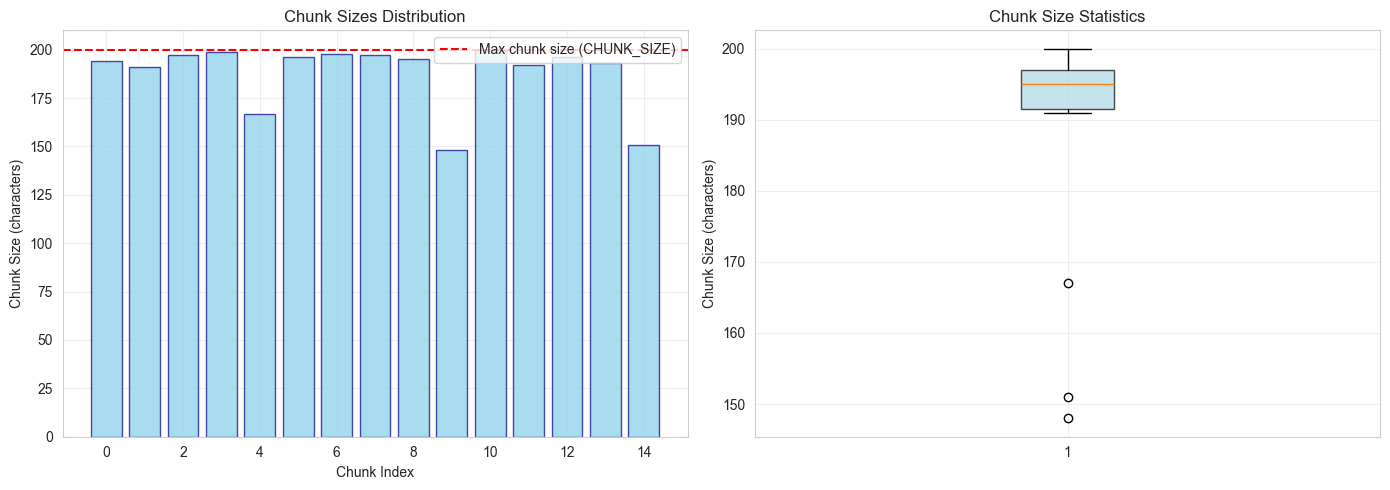

Statistics:
  Total chunks: 15
  Average size: 187.6 characters
  Min size: 148 characters
  Max size: 200 characters
  Std deviation: 16.7 characters


In [10]:
# Visualize chunk sizes
chunk_sizes = [len(chunk.page_content) for chunk in chunks]
chunk_indices = list(range(len(chunks)))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of chunk sizes
ax[0].bar(chunk_indices, chunk_sizes, color='skyblue', edgecolor='navy', alpha=0.7)
ax[0].axhline(y=CHUNK_SIZE, color='r', linestyle='--', label='Max chunk size (CHUNK_SIZE)')
ax[0].set_xlabel('Chunk Index')
ax[0].set_ylabel('Chunk Size (characters)')
ax[0].set_title('Chunk Sizes Distribution')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Box plot
ax[1].boxplot(chunk_sizes, vert=True, patch_artist=True,
              boxprops=dict(facecolor='lightblue', alpha=0.7))
ax[1].set_ylabel('Chunk Size (characters)')
ax[1].set_title('Chunk Size Statistics')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistics:")
print(f"  Total chunks: {len(chunks)}")
print(f"  Average size: {np.mean(chunk_sizes):.1f} characters")
print(f"  Min size: {min(chunk_sizes)} characters")
print(f"  Max size: {max(chunk_sizes)} characters")
print(f"  Std deviation: {np.std(chunk_sizes):.1f} characters")

### 🔍 Visualization 2: Embedding Similarity Matrix

Let's visualize the similarity between different chunks using their embeddings.
This helps us understand how semantically related our documents are.


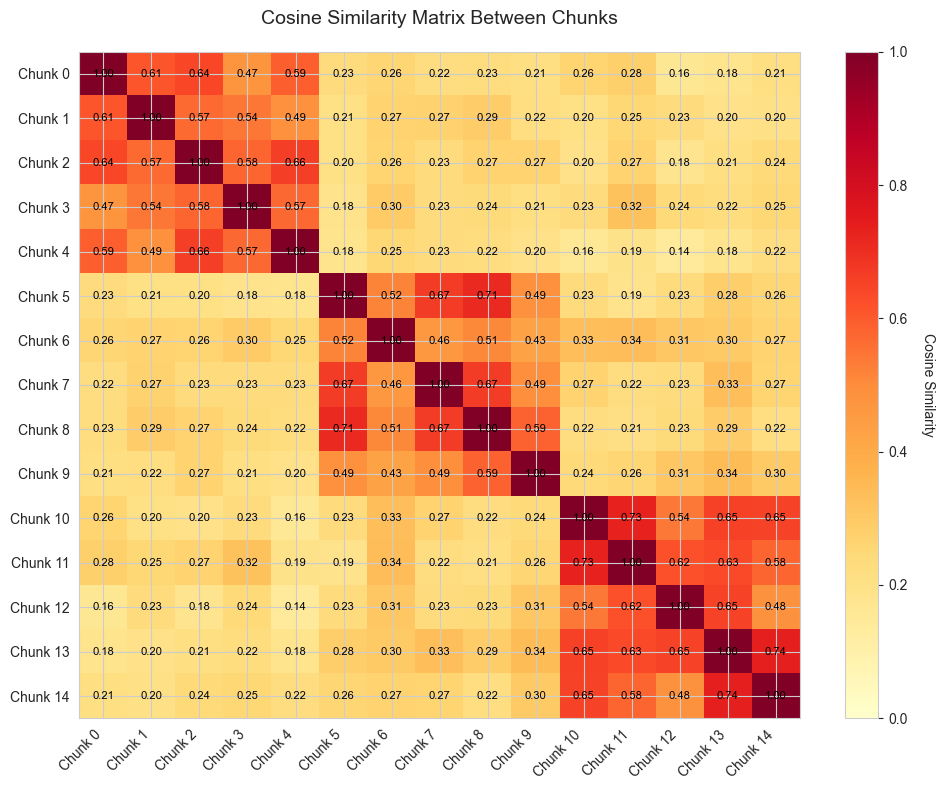


Most similar chunk pairs:
  Chunk 5 <-> Chunk 8: 0.712
  Chunk 10 <-> Chunk 11: 0.729
  Chunk 13 <-> Chunk 14: 0.736


In [11]:
# Get embeddings for all chunks
chunk_texts = [chunk.page_content for chunk in chunks]
chunk_embeddings = embeddings.embed_documents(chunk_texts)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(chunk_embeddings)

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(similarity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

# Set labels
ax.set_xticks(range(len(chunks)))
ax.set_yticks(range(len(chunks)))
ax.set_xticklabels([f'Chunk {i}' for i in range(len(chunks))], rotation=45, ha='right')
ax.set_yticklabels([f'Chunk {i}' for i in range(len(chunks))])
ax.set_title('Cosine Similarity Matrix Between Chunks', fontsize=14, pad=20)

# Add text annotations
for i in range(len(chunks)):
    for j in range(len(chunks)):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

# Print most similar chunk pairs
print("\nMost similar chunk pairs:")
for i in range(len(chunks)):
    for j in range(i+1, len(chunks)):
        sim = similarity_matrix[i, j]
        if sim > 0.7:  # Threshold for high similarity
            print(f"  Chunk {i} <-> Chunk {j}: {sim:.3f}")

### 🎯 Visualization 3: Query-Chunk Similarity

Let's see which chunks are retrieved for different queries and their similarity scores.


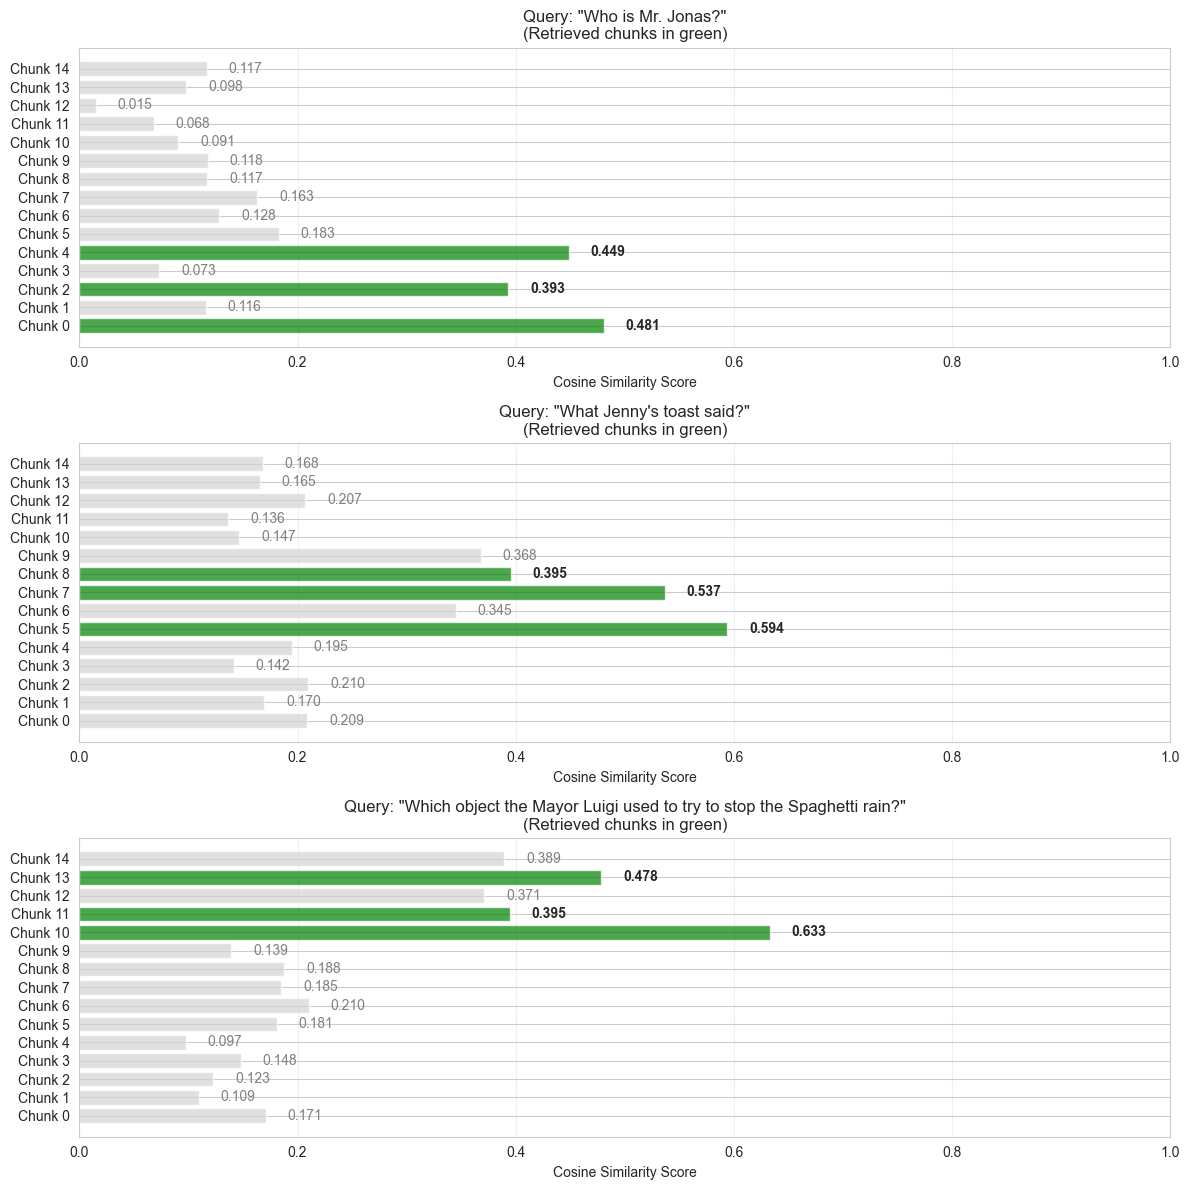


Query: Who is Mr. Jonas?

Retrieved Chunk 1 (similarity score shown in plot above):
  Content: Mr. Jonas, a fluffy orange cat, decided he was tired of just napping all day. He applied for a promotion at the local office. Unfortunately, during th...
  Metadata: {'source': 'local', 'idx': 0, '_id': '7a4e0f33e2504c448d8357360494b141', '_collection_name': 'docs'}

Retrieved Chunk 2 (similarity score shown in plot above):
  Content: became famous for its feline-inspired efficiency seminars. Mr. Jonas even started a newsletter titled 'The Purr-fect Manager,' sharing tips on balanci...
  Metadata: {'source': 'local', 'idx': 0, '_id': 'eecd1605207d497f955ac51c11b71b5c', '_collection_name': 'docs'}

Retrieved Chunk 3 (similarity score shown in plot above):
  Content: loved it, thinking it was a new motivational strategy. Mr. Jonas got the promotion, now supervising the office naps. Soon, he implemented 'cat breaks'...
  Metadata: {'source': 'local', 'idx': 0, '_id': 'f255e2354fdb4ccfa378fe1725

In [12]:
# Test multiple queries
test_queries = [
    "Who is Mr. Jonas?",
    "What Jenny's toast said?",
    "Which object the Mayor Luigi used to try to stop the Spaghetti rain?"
]

fig, axes = plt.subplots(len(test_queries), 1, figsize=(12, 4 * len(test_queries)))

for idx, query in enumerate(test_queries):
    # Get query embedding
    query_embedding = embeddings.embed_query(query)
    
    # Calculate similarities with all chunks
    similarities = [cosine_similarity([query_embedding], [emb])[0][0] 
                   for emb in chunk_embeddings]
    
    # Get top k chunks
    top_k_indices = np.argsort(similarities)[-3:][::-1]
    top_k_similarities = [similarities[i] for i in top_k_indices]
    
    # Plot
    ax = axes[idx]
    colors = ['green' if i in top_k_indices else 'lightgray' for i in range(len(chunks))]
    bars = ax.barh(range(len(chunks)), similarities, color=colors, alpha=0.7)
    ax.set_yticks(range(len(chunks)))
    ax.set_yticklabels([f'Chunk {i}' for i in range(len(chunks))])
    ax.set_xlabel('Cosine Similarity Score')
    ax.set_title(f'Query: "{query}"\n(Retrieved chunks in green)', fontsize=12)
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add similarity values on bars
    for i, (bar, sim) in enumerate(zip(bars, similarities)):
        if i in top_k_indices:
            ax.text(sim + 0.02, i, f'{sim:.3f}', va='center', fontweight='bold')
        else:
            ax.text(sim + 0.02, i, f'{sim:.3f}', va='center', color='gray')

plt.tight_layout()
plt.show()

# Print detailed retrieval results
for query in test_queries:
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"{'='*60}")
    
    # Retrieve using the retriever
    retrieved_docs = retriever.invoke(query)
    
    for i, doc in enumerate(retrieved_docs):
        print(f"\nRetrieved Chunk {i+1} (similarity score shown in plot above):")
        print(f"  Content: {doc.page_content[:150]}...")
        print(f"  Metadata: {doc.metadata}")

### 🗺️ Visualization 4: 2D Embedding Projection

Let's project the high-dimensional embeddings into 2D space using PCA to visualize
the relationships between chunks and queries.


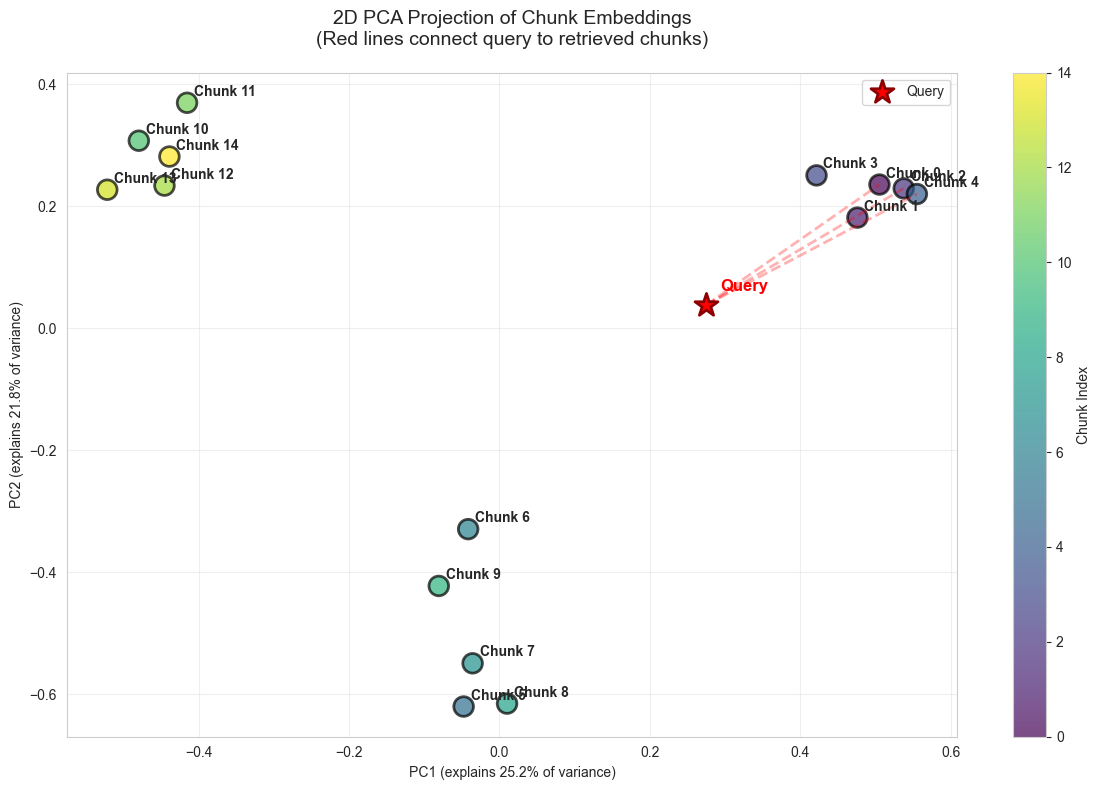

PCA explained variance: 47.02%
(Note: 2D projection may not capture all relationships in high-dimensional space)


In [13]:
# Project embeddings to 2D using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(chunk_embeddings)

# Create a query and get its embedding
query = "Who is Mr. Jonas?"
query_embedding = embeddings.embed_query(query)
query_2d = pca.transform([query_embedding])[0]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot chunk embeddings
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                    s=200, c=range(len(chunks)), cmap='viridis', 
                    alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for chunks
for i, (x, y) in enumerate(embeddings_2d):
    ax.annotate(f'Chunk {i}', (x, y), xytext=(5, 5), 
               textcoords='offset points', fontsize=10, fontweight='bold')

# Plot query embedding
ax.scatter(query_2d[0], query_2d[1], s=300, c='red', marker='*', 
          edgecolors='darkred', linewidth=2, label='Query', zorder=5)
ax.annotate('Query', (query_2d[0], query_2d[1]), xytext=(10, 10),
           textcoords='offset points', fontsize=12, fontweight='bold', color='red')

# Draw lines from query to top 3 chunks
retrieved_docs = retriever.invoke(query)
for doc in retrieved_docs:
    # Find chunk index
    chunk_idx = next(i for i, chunk in enumerate(chunks) 
                    if chunk.page_content == doc.page_content)
    ax.plot([query_2d[0], embeddings_2d[chunk_idx, 0]],
           [query_2d[1], embeddings_2d[chunk_idx, 1]],
           'r--', alpha=0.3, linewidth=2)

ax.set_xlabel(f'PC1 (explains {pca.explained_variance_ratio_[0]:.1%} of variance)')
ax.set_ylabel(f'PC2 (explains {pca.explained_variance_ratio_[1]:.1%} of variance)')
ax.set_title('2D PCA Projection of Chunk Embeddings\n(Red lines connect query to retrieved chunks)', 
            fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Chunk Index')
plt.tight_layout()
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print("(Note: 2D projection may not capture all relationships in high-dimensional space)")

### Compare Different Retrieval Strategies

**Task**: Implement and compare different retrieval strategies:
1. Retrieve different numbers of chunks (k=1, k=3, k=5)
2. Compare `chain_type="stuff"` vs `chain_type="map_reduce"`
3. Analyze how retrieval quality affects answer quality

**Questions to answer**:
- Does retrieving more chunks always improve answers?
- When might fewer chunks be better?
- What are the trade-offs between different chain types?

#### Chain Types in RetrievalQA

The `chain_type` parameter determines how retrieved chunks are combined:

1. **`"stuff"`** (default): Concatenates all retrieved chunks into a single prompt
   - ✅ Simple and fast
   - ❌ Limited by context window size
   - Best for: Small number of chunks, simple queries

2. **`"map_reduce"`**: Processes each chunk separately, then combines results
   - ✅ Handles large numbers of chunks
   - ❌ More API calls, potential information loss
   - Best for: Many chunks, complex documents

3. **`"refine"`**: Iteratively refines the answer with each chunk
   - ✅ High quality answers
   - ❌ Sequential processing, slower
   - Best for: When answer quality is critical

4. **`"map_rerank"`**: Ranks chunks and answers, returns best one
   - ✅ Good for finding best single answer
   - ❌ More complex, requires ranking model
   - Best for: When you need one clear answer


------------------------------------------------------------
Testing Different k Values (number of chunks retrieved)
------------------------------------------------------------

k=1:
  Answer: Mayor Luigi tried to stop the spaghetti rain with umbrellas....
  Time: 1.77 seconds
  Retrieved chunks: 1

k=3:
  Answer: Mayor Luigi tried to stop the spaghetti rain with umbrellas....
  Time: 1.53 seconds
  Retrieved chunks: 3

k=5:
  Answer: Mayor Luigi tried to stop the spaghetti rain with umbrellas....
  Time: 1.45 seconds
  Retrieved chunks: 5

------------------------------------------------------------
Testing Different Chain Types
------------------------------------------------------------

Chain type: stuff
  Answer: Mayor Luigi tried to stop the spaghetti rain with umbrellas....
  Time: 0.82 seconds

Chain type: map_reduce
  Answer: The Mayor Luigi tried to stop it with umbrellas....
  Time: 6.05 seconds

Chain type: refine
  Answer: Mayor Luigi tried to stop the spaghetti rain wit

/Users/martin/Documents/Code/formation/genai_cookbook/.venv/lib/python3.11/site-packages/langchain_classic/chains/combine_documents/map_rerank.py:193: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  results = self.llm_chain.apply_and_parse(



Chain type: map_rerank
  Answer: umbrellas  ...
  Time: 2.52 seconds


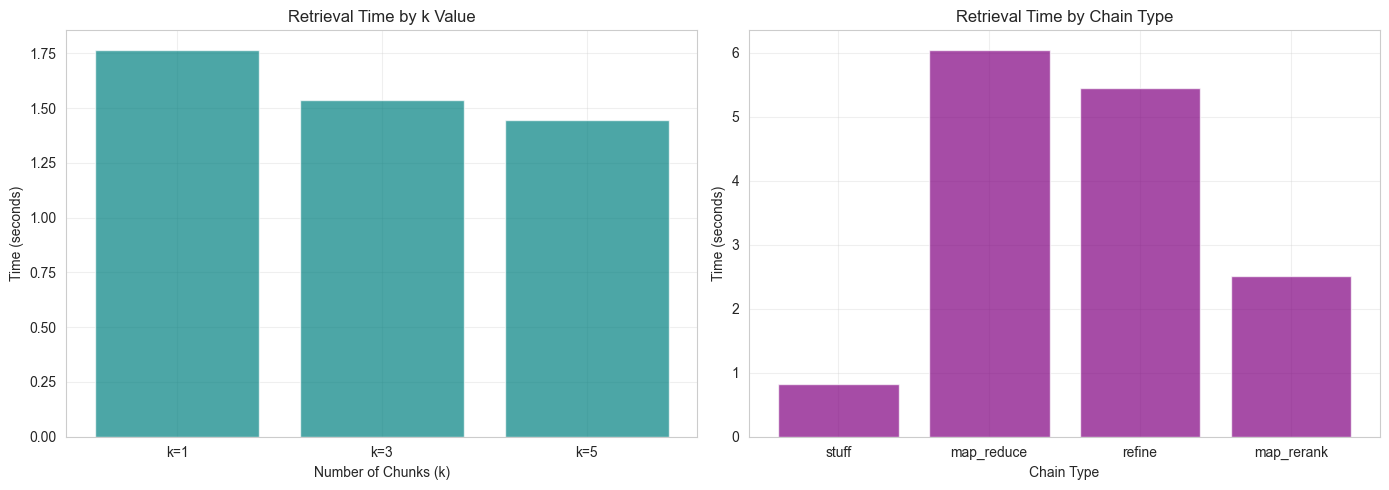


Summary of Findings:

Key Observations:
- More chunks (higher k) may provide more context but take slightly longer
- Chain type 'stuff' is faster but limited by context window
- Chain type 'map_reduce' handles more chunks but requires multiple LLM calls
- Choose k and chain_type based on your specific use case and document size


In [14]:
import time

test_question = "Which object the Mayor Luigi used to try to stop the Spaghetti rain?"

# Test different k values
print("\n" + "-" * 60)
print("Testing Different k Values (number of chunks retrieved)")
print("-" * 60)

k_values = [1, 3, 5]
results_k = {}

for k in k_values:
    retriever_k = vectordb.as_retriever(search_kwargs={"k": k})
    qa_k = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever_k)
    
    start_time = time.time()
    answer_k = qa_k.invoke({"query": test_question})
    elapsed_time = time.time() - start_time
    
    results_k[k] = {
        "answer": answer_k["result"],
        "time": elapsed_time,
        "retriever": retriever_k
    }
    
    print(f"\nk={k}:")
    print(f"  Answer: {answer_k['result'][:150]}...")
    print(f"  Time: {elapsed_time:.2f} seconds")
    print(f"  Retrieved chunks: {len(retriever_k.invoke(test_question))}")

# Test different chain types (with k=3)
print("\n" + "-" * 60)
print("Testing Different Chain Types")
print("-" * 60)

chain_types = ["stuff", "map_reduce", "refine", "map_rerank"]
results_chain = {}

for chain_type in chain_types:
    retriever_ct = vectordb.as_retriever(search_kwargs={"k": 3})
    qa_ct = RetrievalQA.from_chain_type(llm=llm, chain_type=chain_type, retriever=retriever_ct)
    
    start_time = time.time()
    try:
        answer_ct = qa_ct.invoke({"query": test_question})
        elapsed_time = time.time() - start_time
        results_chain[chain_type] = {
            "answer": answer_ct["result"],
            "time": elapsed_time
        }
        print(f"\nChain type: {chain_type}")
        print(f"  Answer: {answer_ct['result'][:150]}...")
        print(f"  Time: {elapsed_time:.2f} seconds")
    except Exception as e:
        print(f"\nChain type: {chain_type} - Error: {e}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# k values comparison
k_list = list(results_k.keys())
times_k = [results_k[k]["time"] for k in k_list]
axes[0].bar([f"k={k}" for k in k_list], times_k, color='teal', alpha=0.7)
axes[0].set_xlabel('Number of Chunks (k)')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Retrieval Time by k Value')
axes[0].grid(True, alpha=0.3)

# Chain types comparison
chain_list = list(results_chain.keys())
times_chain = [results_chain[ct]["time"] for ct in chain_list]
axes[1].bar(chain_list, times_chain, color='purple', alpha=0.7)
axes[1].set_xlabel('Chain Type')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Retrieval Time by Chain Type')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("Summary of Findings:")
print("=" * 60)
print("\nKey Observations:")
print("- More chunks (higher k) may provide more context but take slightly longer")
print("- Chain type 'stuff' is faster but limited by context window")
print("- Chain type 'map_reduce' handles more chunks but requires multiple LLM calls")
print("- Choose k and chain_type based on your specific use case and document size")

### Evaluate RAG Performance

**Task**: 
1. Create a set of test questions and expected answers
2. Implement basic evaluation metrics:
   - Retrieval accuracy (are the right chunks retrieved?)
   - Answer quality (does the answer contain correct information?)
3. Visualize the evaluation results

**Questions to answer**:
- How do you measure RAG system performance?
- What metrics are most important for your use case?
- How can you improve the system based on evaluation results?


In [15]:
# New test dataset based on the whimsical documents
test_cases = [
    {
        "question": "Who got promoted in the office?",
        "expected_keywords": ["Mr. Jonas", "promotion", "supervising"],
        "expected_chunk_keywords": ["Mr. Jonas", "promotion", "office naps"],
        "category": "character"
    },
    {
        "question": "What unusual feature does Jenny's toaster have?",
        "expected_keywords": ["time machine", "messages from the future", "lever"],
        "expected_chunk_keywords": ["toaster", "time machine", "messages"],
        "category": "object"
    },
    {
        "question": "What fell from the sky in Noodleton?",
        "expected_keywords": ["spaghetti", "rain", "noodle"],
        "expected_chunk_keywords": ["spaghetti", "rained", "town of Noodleton"],
        "category": "event"
    },
    {
        "question": "What events involve animals in the stories?",
        "expected_keywords": ["cat breaks", "squirrels waltzing", "Max chasing spaghetti"],
        "expected_chunk_keywords": ["Mr. Jonas", "squirrels", "Max"],
        "category": "animal"
    },
    {
        "question": "What unusual food creations happened in Noodleton?",
        "expected_keywords": ["noodle ice cream", "spaghetti smoothies", "pasta hats"],
        "expected_chunk_keywords": ["chefs", "sky-spaghetti recipes", "pasta"],
        "category": "food"
    }
]

# Use the extended QA chain if available
qa_for_eval = qa_extended if 'qa_extended' in locals() else qa
retriever_for_eval = retriever_extended if 'retriever_extended' in locals() else retriever
chunks_for_eval = chunks_extended if 'chunks_extended' in locals() else chunks

# The evaluation functions remain the same
def evaluate_retrieval(retriever, test_cases, chunks_list):
    results = []
    for test_case in test_cases:
        retrieved = retriever.invoke(test_case["question"])
        retrieved_texts = [doc.page_content.lower() for doc in retrieved]
        keywords_found_in_chunks = [
            keyword for keyword in test_case.get("expected_chunk_keywords", [])
            if any(keyword.lower() in text for text in retrieved_texts)
        ]
        relevance_score = len(keywords_found_in_chunks) / max(len(test_case.get("expected_chunk_keywords", [""])), 1)
        results.append({
            "question": test_case["question"],
            "num_retrieved": len(retrieved),
            "keywords_found": keywords_found_in_chunks,
            "relevance_score": relevance_score,
            "retrieved_chunks": [doc.page_content[:100] + "..." for doc in retrieved]
        })
    return results

def evaluate_answers(qa_chain, test_cases):
    results = []
    for test_case in test_cases:
        try:
            answer = qa_chain.invoke({"query": test_case["question"]})
            answer_text = answer["result"].lower()
            keywords_found = [kw for kw in test_case["expected_keywords"] if kw.lower() in answer_text]
            keyword_coverage = len(keywords_found) / len(test_case["expected_keywords"]) if test_case["expected_keywords"] else 0
            answer_length = len(answer["result"])
            results.append({
                "question": test_case["question"],
                "answer": answer["result"],
                "keywords_found": keywords_found,
                "keyword_coverage": keyword_coverage,
                "answer_length": answer_length,
                "category": test_case.get("category", "unknown")
            })
        except Exception as e:
            results.append({
                "question": test_case["question"],
                "answer": f"Error: {e}",
                "keywords_found": [],
                "keyword_coverage": 0,
                "answer_length": 0,
                "category": test_case.get("category", "unknown")
            })
    return results

# Run evaluations
print("\nEvaluating Retrieval Performance...")
print("-" * 60)
retrieval_results = evaluate_retrieval(retriever_for_eval, test_cases, chunks_for_eval)

print("\nEvaluating Answer Quality...")
print("-" * 60)
answer_results = evaluate_answers(qa_for_eval, test_cases)

# Print detailed results
print("\n" + "=" * 60)
print("Detailed Evaluation Results")
print("=" * 60)

for i, (ret_result, ans_result) in enumerate(zip(retrieval_results, answer_results)):
    print(f"\nTest Case {i+1}: {ret_result['question']}")
    print(f"  Category: {ans_result.get('category', 'unknown')}")
    print(f"  Retrieved chunks: {ret_result['num_retrieved']}")
    print(f"  Retrieval relevance score: {ret_result['relevance_score']:.2%}")
    print(f"  Keywords found in chunks: {ret_result['keywords_found']}")
    print(f"  Keywords found in answer: {ans_result['keywords_found']}")
    print(f"  Keyword coverage: {ans_result['keyword_coverage']:.2%}")
    print(f"  Answer length: {ans_result['answer_length']} characters")

# Aggregate metrics
import numpy as np
avg_relevance = np.mean([r["relevance_score"] for r in retrieval_results])
avg_coverage = np.mean([r["keyword_coverage"] for r in answer_results])
avg_answer_length = np.mean([r["answer_length"] for r in answer_results])

print("\n" + "=" * 60)
print("Aggregate Metrics")
print("=" * 60)
print(f"Average retrieval relevance score: {avg_relevance:.2%}")
print(f"Average keyword coverage: {avg_coverage:.2%}")
print(f"Average answer length: {avg_answer_length:.1f} characters")
print(f"Total test cases: {len(test_cases)}")


Evaluating Retrieval Performance...
------------------------------------------------------------

Evaluating Answer Quality...
------------------------------------------------------------

Detailed Evaluation Results

Test Case 1: Who got promoted in the office?
  Category: character
  Retrieved chunks: 3
  Retrieval relevance score: 100.00%
  Keywords found in chunks: ['Mr. Jonas', 'promotion', 'office naps']
  Keywords found in answer: ['Mr. Jonas', 'promotion']
  Keyword coverage: 66.67%
  Answer length: 42 characters

Test Case 2: What unusual feature does Jenny's toaster have?
  Category: object
  Retrieved chunks: 3
  Retrieval relevance score: 100.00%
  Keywords found in chunks: ['toaster', 'time machine', 'messages']
  Keywords found in answer: ['time machine', 'messages from the future', 'lever']
  Keyword coverage: 100.00%
  Answer length: 211 characters

Test Case 3: What fell from the sky in Noodleton?
  Category: event
  Retrieved chunks: 3
  Retrieval relevance score: 10

### Build a Simple RAG Chatbot

**Task**: 
1. Create an interactive chatbot that uses the RAG system
2. Implement conversation history (optional: use LangChain's memory)
3. Add error handling and user-friendly responses

**Questions to answer**:
- How do you handle follow-up questions in a RAG system?
- Should conversation history be included in the retrieval context?
- How can you improve the user experience?


In [16]:
def simple_rag_chatbot(qa_chain, max_turns=10, conversation_history=None):
    if conversation_history is None:
        conversation_history = []
    
    print("=" * 60)
    print("RAG Chatbot - Type 'quit' to exit, 'history' to see conversation")
    print("=" * 60)
    print("This chatbot uses RAG to answer questions based on the document knowledge base.\n")
    
    turns = 0
    while turns < max_turns:
        try:
            question = input("\nYou: ").strip()
            
            if question.lower() in ['quit', 'exit', 'bye', 'q']:
                print("\nGoodbye! Thanks for using the RAG chatbot!")
                break
            
            if question.lower() == 'history':
                print("\n" + "=" * 60)
                print("Conversation History:")
                print("=" * 60)
                for i, (q, a) in enumerate(conversation_history, 1):
                    print(f"\nTurn {i}:")
                    print(f"  You: {q}")
                    print(f"  Bot: {a[:200]}..." if len(a) > 200 else f"  Bot: {a}")
                continue
            
            if not question:
                print("Please enter a question.")
                continue
            
            print("\nBot: Thinking...")
            answer = qa_chain.invoke({"query": question})
            answer_text = answer['result']
            
            print(f"Bot: {answer_text}")
            conversation_history.append((question, answer_text))
            turns += 1
            
        except KeyboardInterrupt:
            print("\n\nInterrupted by user. Goodbye!")
            break
        except Exception as e:
            print(f"\nError: {e}")
            print("Please try again or type 'quit' to exit.")
    
    return conversation_history

# Demo mode: simple test questions
# "Tell me about Mr. Jonas.",
# "What happens with Jenny's toaster?",
# "Why is Noodleton famous now?"

conversation = simple_rag_chatbot(qa)

RAG Chatbot - Type 'quit' to exit, 'history' to see conversation
This chatbot uses RAG to answer questions based on the document knowledge base.




You:  Tell me about Mr. Jonas.



Bot: Thinking...
Bot: Mr. Jonas is a fluffy orange cat who decided he wanted more than just napping all day. He applied for a promotion at the local office but fell asleep during the interview, which ironically led to him becoming famous for his feline-inspired efficiency seminars. He started a newsletter called 'The Purr-fect Manager,' where he shared tips on balancing work and naps. Eventually, Mr. Jonas got the promotion and became responsible for supervising office naps, implementing 'cat breaks' every hour to encourage employees to take breaks and rest.



You:  What happens with Jenny's toaster?



Bot: Thinking...
Bot: Jenny's toaster is a time machine that sends her messages from the future every time she toasts bread. She discovers a secret lever inside the toaster that allows her to send messages back in time to warn her past self about various issues. This makes her breakfast experience an adventure.



You:  Why is Noodleton famous now?



Bot: Thinking...
Bot: Noodleton is famous now because it transformed into the world's first pasta-themed tourist destination, thanks to the phenomenon of spaghetti raining from the sky. The town became known for its annual 'noodle festivals' led by the town hero, Max, who also invented various unique noodle recipes like noodle ice cream and spaghetti smoothies.



You:  quit



Goodbye! Thanks for using the RAG chatbot!


## 💻 Bonus: Minimal RAG Implementation (Without LangChain Wrappers)

Below is a compact reference implementation showing how to:
- Call the OpenAI embeddings API directly
- Build an in-memory index
- Perform cosine similarity search

This helps you understand what happens under the hood of LangChain.


In [17]:
from openai import OpenAI
import numpy as np

client = OpenAI()

def embed_texts(texts):
    """Convert texts to embeddings using OpenAI API"""
    resp = client.embeddings.create(
        model="text-embedding-3-small", 
        input=texts
    )
    return [d.embedding for d in resp.data]

# Index in memory
raw_texts = [c.page_content for c in chunks]  # Reuse 'chunks' from above
vecs = embed_texts(raw_texts)

def cos_sim(a, b):
    """Calculate cosine similarity between two vectors"""
    return float(np.dot(a, b) / ((np.linalg.norm(a) + 1e-8) * (np.linalg.norm(b) + 1e-8)))

def search(query, k=3):
    """Search for k most similar chunks to the query"""
    # Get query embedding
    qv = embed_texts([query])[0]
    
    # Calculate similarities
    scored = [(cos_sim(qv, v), t) for v, t in zip(vecs, raw_texts)]
    
    # Sort by similarity (descending)
    scored.sort(key=lambda x: x[0], reverse=True)
    
    # Return top k
    return [(score, text) for score, text in scored[:k]]

# Quick demo
results = search("Explain Jonas's story", k=2)
for score, text in results:
    print(f"Similarity: {score:.3f}")
    print(f"Text: {text[:100]}...")
    print()

Similarity: 0.418
Text: Mr. Jonas, a fluffy orange cat, decided he was tired of just napping all day. He applied for a promo...

Similarity: 0.349
Text: loved it, thinking it was a new motivational strategy. Mr. Jonas got the promotion, now supervising ...



## 🎯 Summary

In this notebook, you learned:

1. **RAG Fundamentals**: How retrieval-augmented generation combines document retrieval with language model generation
2. **Pipeline Components**: Document loading, chunking, embedding, vector storage, retrieval, and generation
3. **LangChain Implementation**: How to build a RAG system using LangChain components
4. **Visualization**: How to visualize and analyze different aspects of the RAG pipeline
5. **Best Practices**: Chunk sizing, retrieval strategies, and chain types

## 🚀 Next Steps

- Explore advanced RAG techniques (reranking, query expansion, hybrid search)
- Learn about different embedding models and their trade-offs
- Experiment with different vector databases (ChromaDB, Pinecone, Weaviate)
- Implement more sophisticated retrieval strategies (BM25 + semantic search)
- Build production-ready RAG applications with error handling and monitoring

## 📚 Additional Resources

- [LangChain Documentation](https://python.langchain.com/)
- [Qdrant Documentation](https://github.com/facebookresearch/qdrant)
- [OpenAI Embeddings Guide](https://platform.openai.com/docs/guides/embeddings)
- [RAG Research Paper](https://arxiv.org/abs/2005.11401)
